In [50]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Project imports
import config as cfg
cfg.set_population_config("sea_jpt_cn")

PATHS = cfg.PATHS

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


## Step 1: Load Our SNP Selections

In [51]:
# Paths
PART2_DIR = project_root / "output" / "part2" / "sea_jpt_cn"
GRAPHS_DIR = project_root / "graphs" / "part2" / "sea_jpt_cn"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

# ML Models directory (where 04a and 04b save their top 50 SNP data)
ML_MODELS_DIR = project_root / "output" / "ml_models" / "sea_jpt_cn"

# Our SNP data paths - Use TOP 50 and TOP 40 SNPs from 04a and 04b
FST_ML_DATA_50 = str(ML_MODELS_DIR / "fst_only_top50_ml_data.csv")  # FST-only top 50 SNPs (from 04a)
STAT_ML_DATA_50 = str(ML_MODELS_DIR / "fst_stat_top50_ml_data.csv")  # FST+Statistical top 50 SNPs (from 04b)

# Feature importance files to extract top 40
FST_FEATURES = str(ML_MODELS_DIR / "fst_only_top50_features.csv")  # FST-only feature importance
STAT_FEATURES = str(ML_MODELS_DIR / "fst_stat_top50_features.csv")  # FST+Statistical feature importance

print("Data Paths:")
print(f"  FST-only Top 50 data: {FST_ML_DATA_50}")
print(f"  FST+Statistical Top 50 data: {STAT_ML_DATA_50}")
print(f"  FST-only features: {FST_FEATURES}")
print(f"  FST+Statistical features: {STAT_FEATURES}")

Data Paths:
  FST-only Top 50 data: /home/Plutonium/Documents/BioinfoMidterm/output/ml_models/sea_jpt_cn/fst_only_top50_ml_data.csv
  FST+Statistical Top 50 data: /home/Plutonium/Documents/BioinfoMidterm/output/ml_models/sea_jpt_cn/fst_stat_top50_ml_data.csv
  FST-only features: /home/Plutonium/Documents/BioinfoMidterm/output/ml_models/sea_jpt_cn/fst_only_top50_features.csv
  FST+Statistical features: /home/Plutonium/Documents/BioinfoMidterm/output/ml_models/sea_jpt_cn/fst_stat_top50_features.csv


In [52]:
# Load our SNP data - 50 and 40 SNP versions for both methods
datasets = {}

# Helper function to create subset with top N SNPs
def create_snp_subset(full_df, features_df, n_snps, name):
    """Create a subset with top N SNPs based on feature importance."""
    # Get top N SNP names from feature importance
    if 'snp' in features_df.columns:
        top_n_snps = features_df.head(n_snps)['snp'].tolist()
    elif 'ID' in features_df.columns:
        top_n_snps = features_df.head(n_snps)['ID'].tolist()
    else:
        # Try first column
        top_n_snps = features_df.iloc[:n_snps, 0].tolist()
    
    # Filter to SNPs that exist in the data
    available_snps = [c for c in full_df.columns if c not in ['sample', 'pop', 'source']]
    top_n_snps = [s for s in top_n_snps if s in available_snps][:n_snps]
    
    # Create subset
    subset_df = full_df[['sample', 'pop'] + top_n_snps].copy()
    return subset_df, top_n_snps

# ===== FST-only =====
if os.path.exists(FST_ML_DATA_50):
    fst_df_50 = pd.read_csv(FST_ML_DATA_50)
    fst_snps_50 = [c for c in fst_df_50.columns if c not in ['sample', 'pop', 'source']]
    datasets['Our_FST_only_50'] = fst_df_50
    print(f"✓ Our_FST_only_50: {fst_df_50.shape} ({len(fst_snps_50)} SNPs)")
    
    # Create 40 SNP version
    if os.path.exists(FST_FEATURES):
        fst_features = pd.read_csv(FST_FEATURES)
        fst_df_40, fst_snps_40 = create_snp_subset(fst_df_50, fst_features, 40, 'FST_only_40')
        datasets['Our_FST_only_40'] = fst_df_40
        print(f"✓ Our_FST_only_40: {fst_df_40.shape} ({len(fst_snps_40)} SNPs)")
    else:
        # Fallback: just take first 40 SNP columns
        fst_snps_40 = fst_snps_50[:40]
        fst_df_40 = fst_df_50[['sample', 'pop'] + fst_snps_40].copy()
        datasets['Our_FST_only_40'] = fst_df_40
        print(f"✓ Our_FST_only_40 (fallback): {fst_df_40.shape} ({len(fst_snps_40)} SNPs)")
else:
    print(f"⚠ WARNING: FST-only data not found: {FST_ML_DATA_50}")

# ===== FST+Statistical =====
if os.path.exists(STAT_ML_DATA_50):
    stat_df_50 = pd.read_csv(STAT_ML_DATA_50)
    stat_snps_50 = [c for c in stat_df_50.columns if c not in ['sample', 'pop', 'source']]
    datasets['Our_FST_Statistical_50'] = stat_df_50
    print(f"✓ Our_FST_Statistical_50: {stat_df_50.shape} ({len(stat_snps_50)} SNPs)")
    
    # Create 40 SNP version
    if os.path.exists(STAT_FEATURES):
        stat_features = pd.read_csv(STAT_FEATURES)
        stat_df_40, stat_snps_40 = create_snp_subset(stat_df_50, stat_features, 40, 'FST_Stat_40')
        datasets['Our_FST_Statistical_40'] = stat_df_40
        print(f"✓ Our_FST_Statistical_40: {stat_df_40.shape} ({len(stat_snps_40)} SNPs)")
    else:
        # Fallback: just take first 40 SNP columns
        stat_snps_40 = stat_snps_50[:40]
        stat_df_40 = stat_df_50[['sample', 'pop'] + stat_snps_40].copy()
        datasets['Our_FST_Statistical_40'] = stat_df_40
        print(f"✓ Our_FST_Statistical_40 (fallback): {stat_df_40.shape} ({len(stat_snps_40)} SNPs)")
else:
    print(f"⚠ WARNING: FST+Statistical data not found: {STAT_ML_DATA_50}")

print(f"\nLoaded {len(datasets)} of our SNP datasets")

✓ Our_FST_only_50: (504, 52) (50 SNPs)
✓ Our_FST_only_40: (504, 42) (40 SNPs)
✓ Our_FST_Statistical_50: (504, 52) (50 SNPs)
✓ Our_FST_Statistical_40: (504, 42) (40 SNPs)

Loaded 4 of our SNP datasets


In [53]:
# Load known AISNP panel data (from Part 2)
known_panels = list(PART2_DIR.glob("*_ml_matrix.csv"))

print(f"\nFound {len(known_panels)} known AISNP panels:")
for f in known_panels:
    name = f.stem.replace('_ml_matrix', '')
    df = pd.read_csv(f)
    datasets[f'Known_{name}'] = df
    snp_cols = [c for c in df.columns if c not in ['sample', 'pop', 'source']]
    print(f"  - Known_{name}: {df.shape} ({len(snp_cols)} SNPs)")

print(f"\nTotal datasets loaded: {len(datasets)}")
print("\nOur datasets:")
for name in datasets.keys():
    if 'Our' in name:
        print(f"  ★ {name}")
print("\nKnown panels:")
for name in datasets.keys():
    if 'Known' in name:
        print(f"  ○ {name}")


Found 5 known AISNP panels:
  - Known_cal_et_al: (504, 54) (52 SNPs)
  - Known_seldin_128: (504, 126) (124 SNPs)
  - Known_forenseq: (504, 57) (55 SNPs)
  - Known_kidd_55: (504, 55) (53 SNPs)
  - Known_hsiao_lin_hwa: (504, 127) (125 SNPs)

Total datasets loaded: 9

Our datasets:
  ★ Our_FST_only_50
  ★ Our_FST_only_40
  ★ Our_FST_Statistical_50
  ★ Our_FST_Statistical_40

Known panels:
  ○ Known_cal_et_al
  ○ Known_seldin_128
  ○ Known_forenseq
  ○ Known_kidd_55
  ○ Known_hsiao_lin_hwa


## Step 2: Dataset Overview

In [54]:
# Create overview table
overview = []

for name, df in datasets.items():
    snp_cols = [c for c in df.columns if c not in ['sample', 'pop', 'source']]
    is_ours = 'Our' in name
    
    overview.append({
        'Source': name,
        'Type': 'Our Selection' if is_ours else 'Known Panel',
        'Samples': len(df),
        'SNPs': len(snp_cols),
        'Populations': df['pop'].nunique(),
        'Pop_List': ', '.join(sorted(df['pop'].unique()))
    })

overview_df = pd.DataFrame(overview)
print("DATASET OVERVIEW")
print("="*80)
display(overview_df)

DATASET OVERVIEW


,Source,Type,Samples,SNPs,Populations,Pop_List
0,Our_FST_only_50,Our Selection,504,50,3,"CN, JPT, SEA"
1,Our_FST_only_40,Our Selection,504,40,3,"CN, JPT, SEA"
2,Our_FST_Statistical_50,Our Selection,504,50,3,"CN, JPT, SEA"
3,Our_FST_Statistical_40,Our Selection,504,40,3,"CN, JPT, SEA"
4,Known_cal_et_al,Known Panel,504,52,3,"CN, JPT, SEA"
5,Known_seldin_128,Known Panel,504,124,3,"CN, JPT, SEA"
6,Known_forenseq,Known Panel,504,55,3,"CN, JPT, SEA"
7,Known_kidd_55,Known Panel,504,53,3,"CN, JPT, SEA"
8,Known_hsiao_lin_hwa,Known Panel,504,125,3,"CN, JPT, SEA"


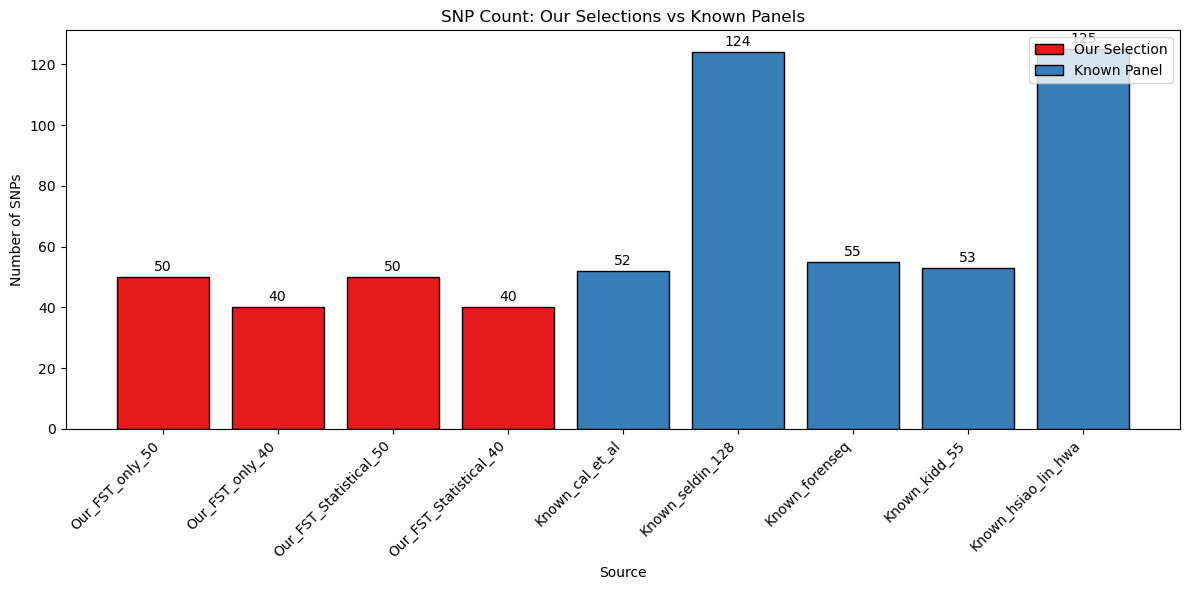

In [55]:
# Visualization: SNP counts comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Color by type
colors = ['#e41a1c' if 'Our' in name else '#377eb8' for name in overview_df['Source']]
bars = ax.bar(overview_df['Source'], overview_df['SNPs'], color=colors, edgecolor='black')

ax.set_xlabel('Source')
ax.set_ylabel('Number of SNPs')
ax.set_title('SNP Count: Our Selections vs Known Panels')
ax.set_xticklabels(overview_df['Source'], rotation=45, ha='right')

# Add count labels
for bar, count in zip(bars, overview_df['SNPs']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontsize=10)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e41a1c', edgecolor='black', label='Our Selection'),
    Patch(facecolor='#377eb8', edgecolor='black', label='Known Panel')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'our_vs_known_snp_counts.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 3: Define Classifiers

In [56]:
# Define classifiers for comparison
classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        random_state=42, n_jobs=-1, verbosity=0
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf', random_state=42, probability=True
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'MLP Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True
    )
}

print(f"Classifiers: {len(classifiers)}")
for name in classifiers.keys():
    print(f"  - {name}")

Classifiers: 7
  - Random Forest
  - XGBoost
  - Logistic Regression
  - SVM (RBF)
  - K-Nearest Neighbors
  - Gradient Boosting
  - MLP Neural Network


## Step 4: K-Fold Cross-Validation on All Sources

In [57]:
# Helper function to run model comparison
def run_model_comparison(df, classifiers, n_folds=5, source_name='Unknown'):
    """Run K-fold CV on all classifiers for a dataset."""
    
    # Prepare data
    snp_cols = [c for c in df.columns if c not in ['sample', 'pop', 'source']]
    X = df[snp_cols].values
    y = df['pop'].values
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # CV setup
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    results = []
    
    for name, clf in classifiers.items():
        # Clone classifier
        clf_clone = clf.__class__(**clf.get_params())
        
        # Use scaled data for appropriate classifiers
        if 'SVM' in name or 'Logistic' in name or 'MLP' in name:
            X_use = X_scaled
        else:
            X_use = X
        
        # Use encoded labels for XGBoost and MLP
        if 'XGBoost' in name or 'MLP' in name:
            y_use = y_encoded
        else:
            y_use = y
        
        try:
            scoring = {
                'accuracy': 'accuracy',
                'f1_weighted': 'f1_weighted'
            }
            
            scores = cross_validate(clf_clone, X_use, y_use, cv=cv, scoring=scoring)
            
            results.append({
                'Source': source_name,
                'Model': name,
                'Accuracy_Mean': scores['test_accuracy'].mean(),
                'Accuracy_Std': scores['test_accuracy'].std(),
                'F1_Mean': scores['test_f1_weighted'].mean(),
                'F1_Std': scores['test_f1_weighted'].std(),
                'N_SNPs': len(snp_cols)
            })
        except Exception as e:
            print(f"  Error with {name}: {e}")
            results.append({
                'Source': source_name,
                'Model': name,
                'Accuracy_Mean': np.nan,
                'Accuracy_Std': np.nan,
                'F1_Mean': np.nan,
                'F1_Std': np.nan,
                'N_SNPs': len(snp_cols)
            })
    
    return pd.DataFrame(results)

In [58]:
# Run K-fold CV on all datasets
N_FOLDS = 5

all_results = []

for source_name, df in datasets.items():
    print(f"\nProcessing: {source_name}...")
    results = run_model_comparison(
        df=df,
        classifiers=classifiers,
        n_folds=N_FOLDS,
        source_name=source_name
    )
    all_results.append(results)

# Combine all results
results_df = pd.concat(all_results, ignore_index=True)

# Add type column
results_df['Type'] = results_df['Source'].apply(lambda x: 'Our Selection' if 'Our' in x else 'Known Panel')

print(f"\n\n{'='*70}")
print("ALL RESULTS")
print(f"{'='*70}")
display(results_df)


Processing: Our_FST_only_50...

Processing: Our_FST_only_40...

Processing: Our_FST_Statistical_50...

Processing: Our_FST_Statistical_40...

Processing: Known_cal_et_al...

Processing: Known_seldin_128...

Processing: Known_forenseq...

Processing: Known_kidd_55...

Processing: Known_hsiao_lin_hwa...


ALL RESULTS


,Source,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,N_SNPs,Type
0,Our_FST_only_50,Random Forest,0.934515,0.004970,0.933456,0.005672,50,Our Selection
1,Our_FST_only_50,XGBoost,0.904713,0.020668,0.903357,0.020384,50,Our Selection
2,Our_FST_only_50,Logistic Regression,0.926614,0.020308,0.926006,0.021170,50,Our Selection
3,Our_FST_only_50,SVM (RBF),0.944455,0.020359,0.944246,0.020520,50,Our Selection
4,Our_FST_only_50,K-Nearest Neighbors,0.841208,0.029759,0.832761,0.029337,50,Our Selection
...,...,...,...,...,...,...,...,...
58,Known_hsiao_lin_hwa,Logistic Regression,0.559465,0.046402,0.558662,0.046918,125,Known Panel
59,Known_hsiao_lin_hwa,SVM (RBF),0.626891,0.049907,0.601965,0.059657,125,Known Panel
60,Known_hsiao_lin_hwa,K-Nearest Neighbors,0.444455,0.050318,0.415042,0.050799,125,Known Panel
61,Known_hsiao_lin_hwa,Gradient Boosting,0.535663,0.046681,0.525195,0.050748,125,Known Panel


## Step 5: Performance Comparison - Our Methods vs Known Panels

In [59]:
# Summary by source
print("="*70)
print("PERFORMANCE SUMMARY BY SOURCE")
print("="*70)

source_summary = results_df.groupby('Source').agg({
    'Accuracy_Mean': ['mean', 'max'],
    'F1_Mean': ['mean', 'max'],
    'N_SNPs': 'first'
}).round(4)

source_summary.columns = ['Avg_Accuracy', 'Best_Accuracy', 'Avg_F1', 'Best_F1', 'N_SNPs']
source_summary = source_summary.sort_values('Best_Accuracy', ascending=False)

display(source_summary)

PERFORMANCE SUMMARY BY SOURCE


,Avg_Accuracy,Best_Accuracy,Avg_F1,Best_F1,N_SNPs
Source,,,,,
Our_FST_only_50,0.9036,0.9445,0.9017,0.9442,50
Our_FST_Statistical_50,0.9042,0.9285,0.9036,0.9285,50
Our_FST_only_40,0.8968,0.9167,0.8954,0.9165,40
Our_FST_Statistical_40,0.8943,0.9147,0.8935,0.9145,40
Known_cal_et_al,0.8866,0.9107,0.8855,0.9107,52
Known_kidd_55,0.6068,0.6726,0.5983,0.6718,53
Known_forenseq,0.6082,0.6726,0.6006,0.6710,55
Known_seldin_128,0.5924,0.6488,0.5752,0.6369,124
Known_hsiao_lin_hwa,0.5456,0.6269,0.5282,0.6020,125


In [60]:
# Best model per source
print("\nBEST MODEL PER SOURCE:")
print("-"*70)

for source in results_df['Source'].unique():
    source_data = results_df[results_df['Source'] == source]
    best_idx = source_data['Accuracy_Mean'].idxmax()
    best = source_data.loc[best_idx]
    
    marker = "★" if 'Our' in source else "○"
    print(f"{marker} {source}: {best['Model']} ({best['Accuracy_Mean']:.4f} ± {best['Accuracy_Std']:.4f})")


BEST MODEL PER SOURCE:
----------------------------------------------------------------------
★ Our_FST_only_50: SVM (RBF) (0.9445 ± 0.0204)
★ Our_FST_only_40: SVM (RBF) (0.9167 ± 0.0270)
★ Our_FST_Statistical_50: SVM (RBF) (0.9285 ± 0.0134)
★ Our_FST_Statistical_40: SVM (RBF) (0.9147 ± 0.0171)
○ Known_cal_et_al: SVM (RBF) (0.9107 ± 0.0229)
○ Known_seldin_128: SVM (RBF) (0.6488 ± 0.0432)
○ Known_forenseq: Logistic Regression (0.6726 ± 0.0473)
○ Known_kidd_55: Logistic Regression (0.6726 ± 0.0541)
○ Known_hsiao_lin_hwa: SVM (RBF) (0.6269 ± 0.0499)


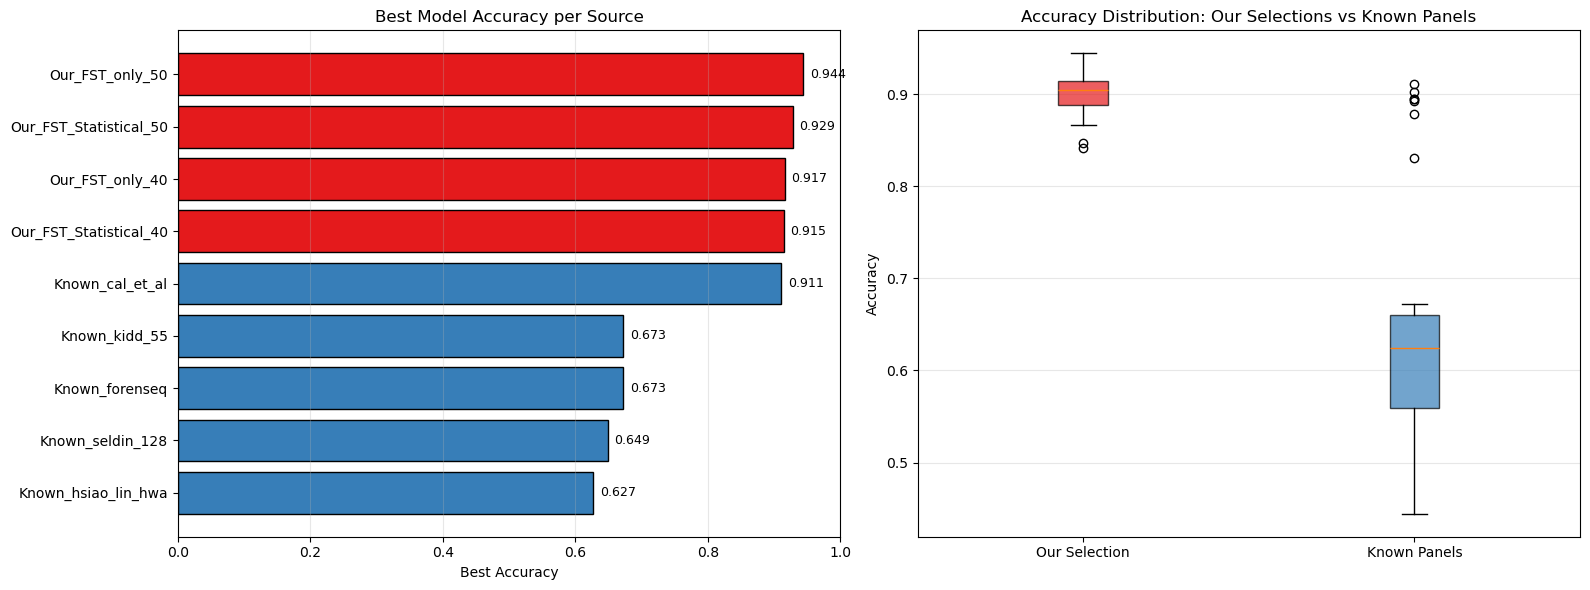

In [61]:
# Visualization: Accuracy comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors
type_colors = {'Our Selection': '#e41a1c', 'Known Panel': '#377eb8'}

# Plot 1: Best accuracy per source
ax = axes[0]
pivot_best = results_df.groupby('Source')['Accuracy_Mean'].max().sort_values(ascending=True)
colors = [type_colors['Our Selection'] if 'Our' in s else type_colors['Known Panel'] for s in pivot_best.index]

bars = ax.barh(pivot_best.index, pivot_best.values, color=colors, edgecolor='black')
ax.set_xlabel('Best Accuracy')
ax.set_title('Best Model Accuracy per Source')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, pivot_best.values):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontsize=9)

# Plot 2: Box plot by type
ax = axes[1]
our_data = results_df[results_df['Type'] == 'Our Selection']['Accuracy_Mean']
known_data = results_df[results_df['Type'] == 'Known Panel']['Accuracy_Mean']

bp = ax.boxplot([our_data, known_data], labels=['Our Selection', 'Known Panels'],
                patch_artist=True)

bp['boxes'][0].set_facecolor('#e41a1c')
bp['boxes'][1].set_facecolor('#377eb8')
for box in bp['boxes']:
    box.set_alpha(0.7)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Distribution: Our Selections vs Known Panels')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'our_vs_known_performance.png'), dpi=150, bbox_inches='tight')
plt.show()

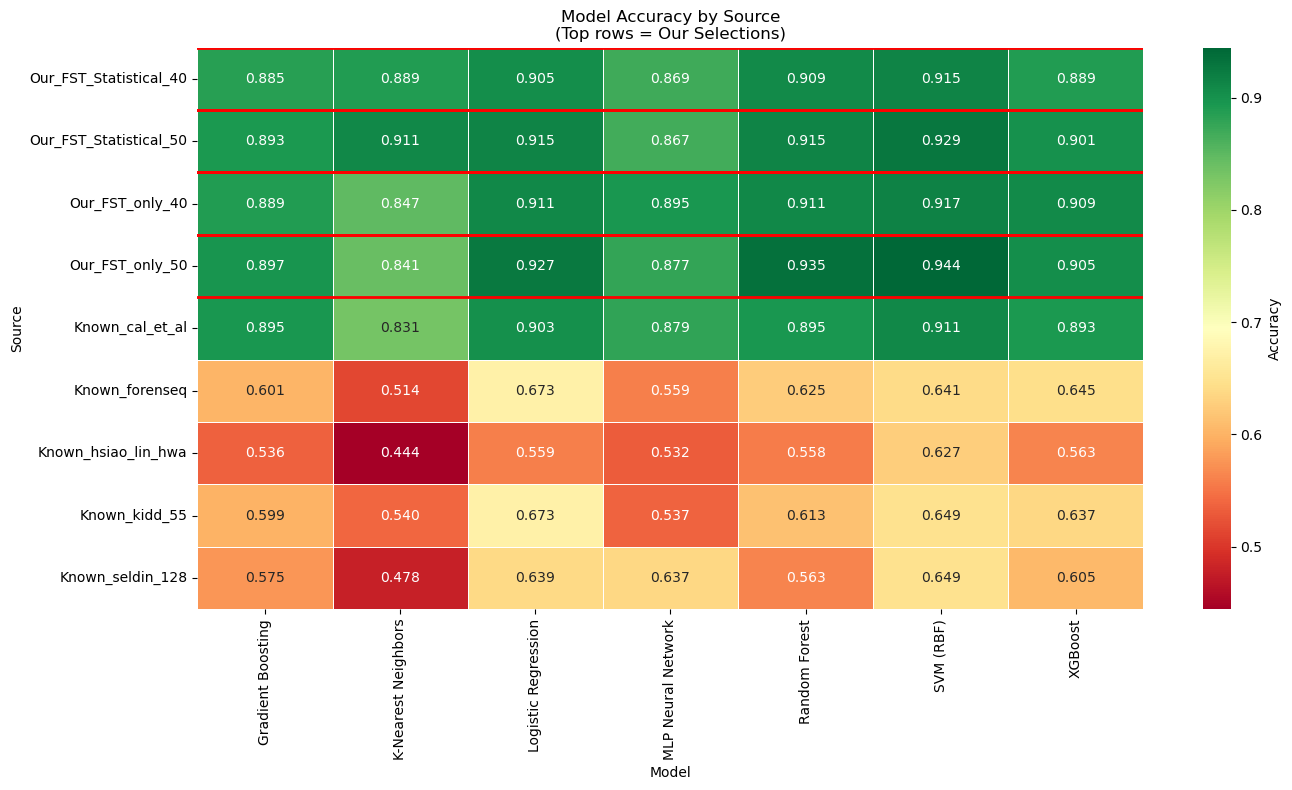

In [62]:
# Heatmap: Accuracy by Source and Model
fig, ax = plt.subplots(figsize=(14, 8))

pivot_heatmap = results_df.pivot(index='Source', columns='Model', values='Accuracy_Mean')

# Sort sources - Our first, then known
our_sources = [s for s in pivot_heatmap.index if 'Our' in s]
known_sources = [s for s in pivot_heatmap.index if 'Our' not in s]
ordered_sources = our_sources + sorted(known_sources)
pivot_heatmap = pivot_heatmap.loc[ordered_sources]

sns.heatmap(pivot_heatmap, annot=True, fmt='.3f', cmap='RdYlGn',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_title('Model Accuracy by Source\n(Top rows = Our Selections)')
ax.set_xlabel('Model')
ax.set_ylabel('Source')

# Highlight our rows
for i, source in enumerate(ordered_sources):
    if 'Our' in source:
        ax.axhline(y=i, color='red', linewidth=2)
        ax.axhline(y=i+1, color='red', linewidth=2)

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'our_vs_known_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 6: FST-only vs FST+Statistical Direct Comparison

In [63]:
# Direct comparison of our methods (40 and 50 SNPs)
our_results = results_df[results_df['Type'] == 'Our Selection'].copy()

if len(our_results) > 0:
    print("="*70)
    print("FST-only vs FST+Statistical (40 and 50 SNPs)")
    print("="*70)
    
    # Create pivot table
    our_pivot = our_results.pivot(index='Model', columns='Source', values='Accuracy_Mean')
    display(our_pivot.round(4))
    
    # Calculate differences for each comparison
    print("\n" + "-"*70)
    print("PAIRWISE COMPARISONS")
    print("-"*70)
    
    comparisons = [
        ('Our_FST_only_50', 'Our_FST_Statistical_50', '50 SNPs: FST+Stat - FST-only'),
        ('Our_FST_only_40', 'Our_FST_Statistical_40', '40 SNPs: FST+Stat - FST-only'),
        ('Our_FST_only_40', 'Our_FST_only_50', 'FST-only: 50 SNPs - 40 SNPs'),
        ('Our_FST_Statistical_40', 'Our_FST_Statistical_50', 'FST+Stat: 50 SNPs - 40 SNPs'),
    ]
    
    for col1, col2, label in comparisons:
        if col1 in our_pivot.columns and col2 in our_pivot.columns:
            diff = our_pivot[col2] - our_pivot[col1]
            avg_diff = diff.mean()
            better = 'Second' if avg_diff > 0 else 'First'
            print(f"\n{label}:")
            print(f"  Average difference: {avg_diff:+.4f} ({better} is better)")
            print(f"  Models where second is better: {(diff > 0).sum()}/{len(diff)}")

FST-only vs FST+Statistical (40 and 50 SNPs)


Source,Our_FST_Statistical_40,Our_FST_Statistical_50,Our_FST_only_40,Our_FST_only_50
Model,,,,
Gradient Boosting,0.8849,0.8928,0.8888,0.8968
K-Nearest Neighbors,0.8889,0.9107,0.8472,0.8412
Logistic Regression,0.9048,0.9147,0.9107,0.9266
MLP Neural Network,0.8691,0.8670,0.8949,0.8770
Random Forest,0.9088,0.9147,0.9107,0.9345
SVM (RBF),0.9147,0.9285,0.9167,0.9445
XGBoost,0.8889,0.9008,0.9086,0.9047



----------------------------------------------------------------------
PAIRWISE COMPARISONS
----------------------------------------------------------------------

50 SNPs: FST+Stat - FST-only:
  Average difference: +0.0006 (Second is better)
  Models where second is better: 1/7

40 SNPs: FST+Stat - FST-only:
  Average difference: -0.0025 (First is better)
  Models where second is better: 1/7

FST-only: 50 SNPs - 40 SNPs:
  Average difference: +0.0068 (Second is better)
  Models where second is better: 4/7

FST+Stat: 50 SNPs - 40 SNPs:
  Average difference: +0.0099 (Second is better)
  Models where second is better: 6/7


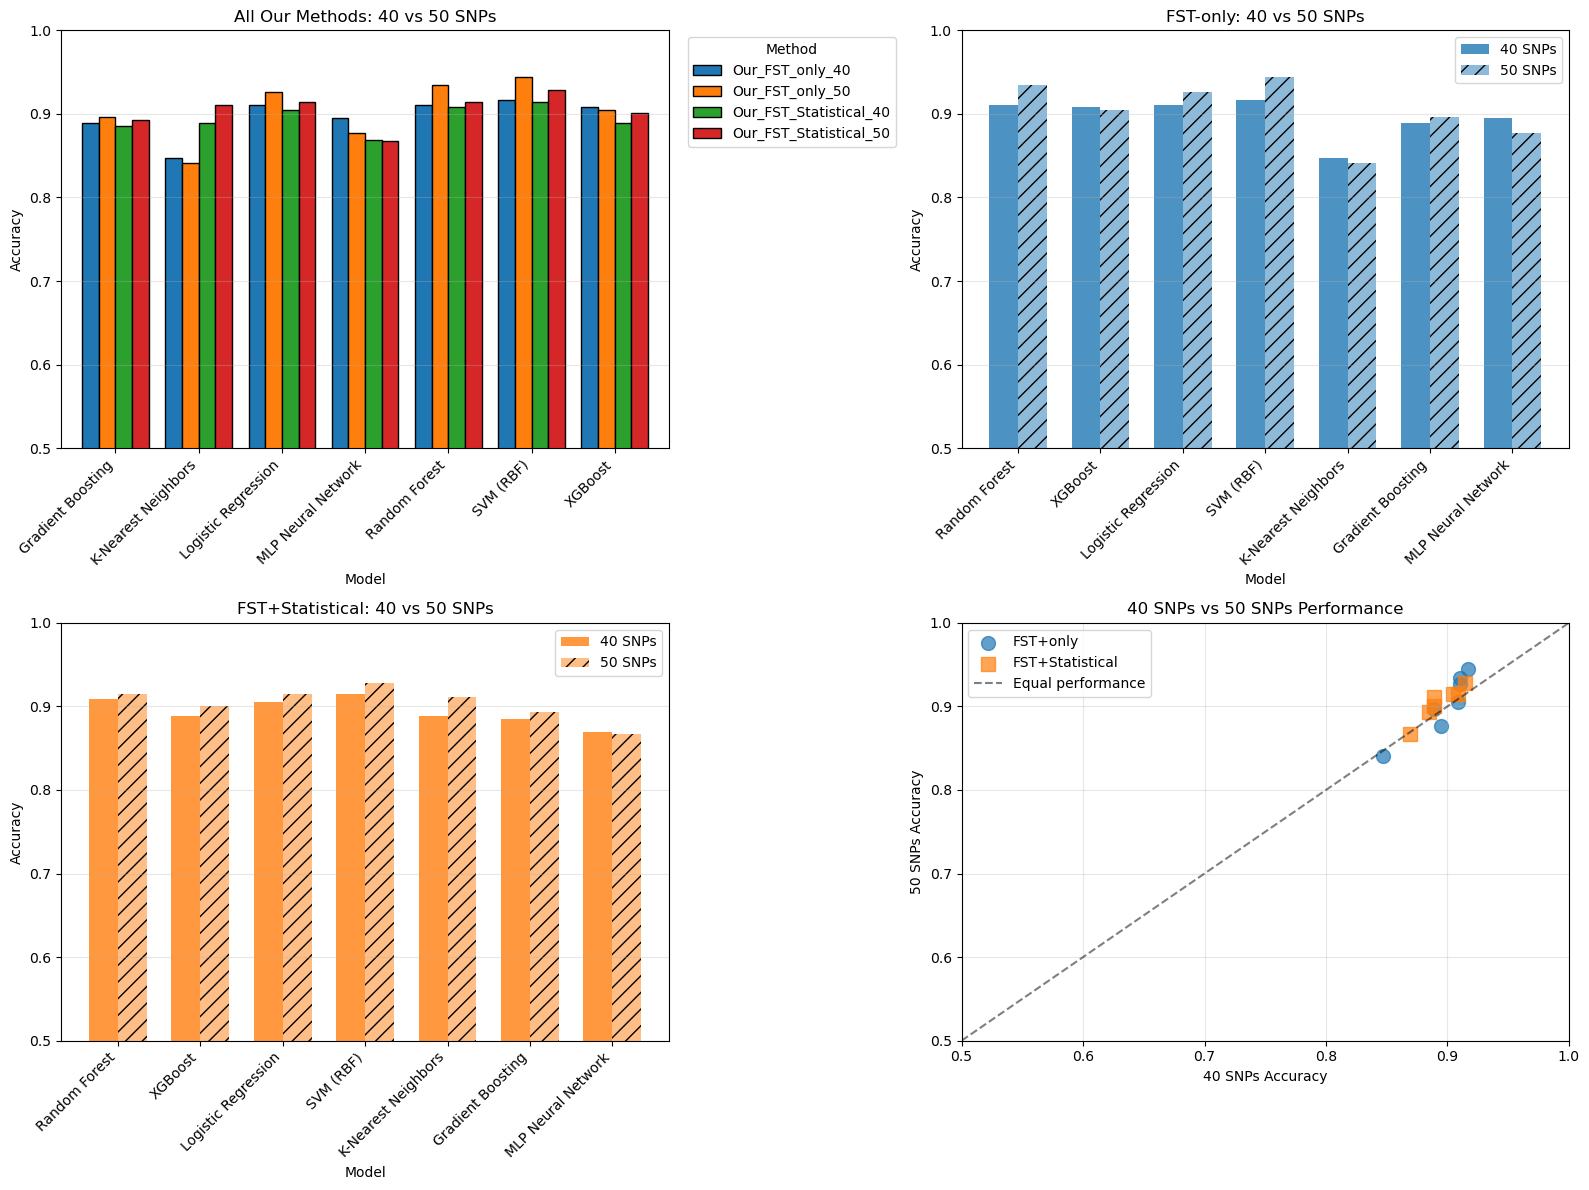

Plot saved: /home/Plutonium/Documents/BioinfoMidterm/graphs/part2/sea_jpt_cn/our_methods_40_vs_50_comparison.png


In [64]:
# Visualization: 40 vs 50 SNPs for both methods
our_sources = [s for s in results_df['Source'].unique() if 'Our' in s]

if len(our_sources) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Bar comparison - All our methods
    ax = axes[0, 0]
    our_data = results_df[results_df['Source'].isin(our_sources)]
    pivot = our_data.pivot(index='Model', columns='Source', values='Accuracy_Mean')
    
    # Sort columns: FST_only_40, FST_only_50, FST_Statistical_40, FST_Statistical_50
    col_order = ['Our_FST_only_40', 'Our_FST_only_50', 'Our_FST_Statistical_40', 'Our_FST_Statistical_50']
    col_order = [c for c in col_order if c in pivot.columns]
    pivot = pivot[col_order]
    
    pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('All Our Methods: 40 vs 50 SNPs')
    ax.legend(title='Method', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0.5, 1.0)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: FST-only 40 vs 50
    ax = axes[0, 1]
    if 'Our_FST_only_40' in results_df['Source'].values and 'Our_FST_only_50' in results_df['Source'].values:
        fst_40 = results_df[results_df['Source'] == 'Our_FST_only_40'].set_index('Model')['Accuracy_Mean']
        fst_50 = results_df[results_df['Source'] == 'Our_FST_only_50'].set_index('Model')['Accuracy_Mean']
        common = fst_40.index.intersection(fst_50.index)
        
        x = np.arange(len(common))
        width = 0.35
        ax.bar(x - width/2, fst_40.loc[common], width, label='40 SNPs', color='#1f77b4', alpha=0.8)
        ax.bar(x + width/2, fst_50.loc[common], width, label='50 SNPs', color='#1f77b4', alpha=0.5, hatch='//')
        ax.set_xlabel('Model')
        ax.set_ylabel('Accuracy')
        ax.set_title('FST-only: 40 vs 50 SNPs')
        ax.set_xticks(x)
        ax.set_xticklabels(common, rotation=45, ha='right')
        ax.legend()
        ax.set_ylim(0.5, 1.0)
        ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: FST+Statistical 40 vs 50
    ax = axes[1, 0]
    if 'Our_FST_Statistical_40' in results_df['Source'].values and 'Our_FST_Statistical_50' in results_df['Source'].values:
        stat_40 = results_df[results_df['Source'] == 'Our_FST_Statistical_40'].set_index('Model')['Accuracy_Mean']
        stat_50 = results_df[results_df['Source'] == 'Our_FST_Statistical_50'].set_index('Model')['Accuracy_Mean']
        common = stat_40.index.intersection(stat_50.index)
        
        x = np.arange(len(common))
        width = 0.35
        ax.bar(x - width/2, stat_40.loc[common], width, label='40 SNPs', color='#ff7f0e', alpha=0.8)
        ax.bar(x + width/2, stat_50.loc[common], width, label='50 SNPs', color='#ff7f0e', alpha=0.5, hatch='//')
        ax.set_xlabel('Model')
        ax.set_ylabel('Accuracy')
        ax.set_title('FST+Statistical: 40 vs 50 SNPs')
        ax.set_xticks(x)
        ax.set_xticklabels(common, rotation=45, ha='right')
        ax.legend()
        ax.set_ylim(0.5, 1.0)
        ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Scatter comparison - 40 SNPs vs 50 SNPs
    ax = axes[1, 1]
    for method, color, marker in [('FST_only', '#1f77b4', 'o'), ('FST_Statistical', '#ff7f0e', 's')]:
        src_40 = f'Our_{method}_40'
        src_50 = f'Our_{method}_50'
        if src_40 in results_df['Source'].values and src_50 in results_df['Source'].values:
            data_40 = results_df[results_df['Source'] == src_40].set_index('Model')['Accuracy_Mean']
            data_50 = results_df[results_df['Source'] == src_50].set_index('Model')['Accuracy_Mean']
            common = data_40.index.intersection(data_50.index)
            ax.scatter(data_40.loc[common], data_50.loc[common], s=100, alpha=0.7, 
                      color=color, marker=marker, label=method.replace('_', '+'))
    
    ax.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.5, label='Equal performance')
    ax.set_xlabel('40 SNPs Accuracy')
    ax.set_ylabel('50 SNPs Accuracy')
    ax.set_title('40 SNPs vs 50 SNPs Performance')
    ax.legend()
    ax.set_xlim(0.5, 1.0)
    ax.set_ylim(0.5, 1.0)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(str(GRAPHS_DIR / 'our_methods_40_vs_50_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved: {GRAPHS_DIR / 'our_methods_40_vs_50_comparison.png'}")

## Step 6a: PCA Comparison - FST-only vs FST+Statistical

In [65]:
# PCA Comparison: FST-only vs FST+Statistical
from sklearn.decomposition import PCA

# Prepare data for PCA
pca_datasets = {}

# Get our 4 datasets
for name in ['Our_FST_only_40', 'Our_FST_only_50', 'Our_FST_Statistical_40', 'Our_FST_Statistical_50']:
    if name in datasets:
        df = datasets[name]
        snp_cols = [c for c in df.columns if c not in ['sample', 'pop', 'source']]
        X = df[snp_cols].values
        y = df['pop'].values
        
        # Standardize
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        pca_datasets[name] = {
            'X_pca': X_pca,
            'y': y,
            'explained_variance': pca.explained_variance_ratio_
        }
        
        print(f"{name}: PC1={pca.explained_variance_ratio_[0]:.3f}, PC2={pca.explained_variance_ratio_[1]:.3f}")

print(f"\nLoaded {len(pca_datasets)} datasets for PCA comparison")

Our_FST_only_40: PC1=0.240, PC2=0.105
Our_FST_only_50: PC1=0.209, PC2=0.107
Our_FST_Statistical_40: PC1=0.216, PC2=0.090
Our_FST_Statistical_50: PC1=0.190, PC2=0.078

Loaded 4 datasets for PCA comparison


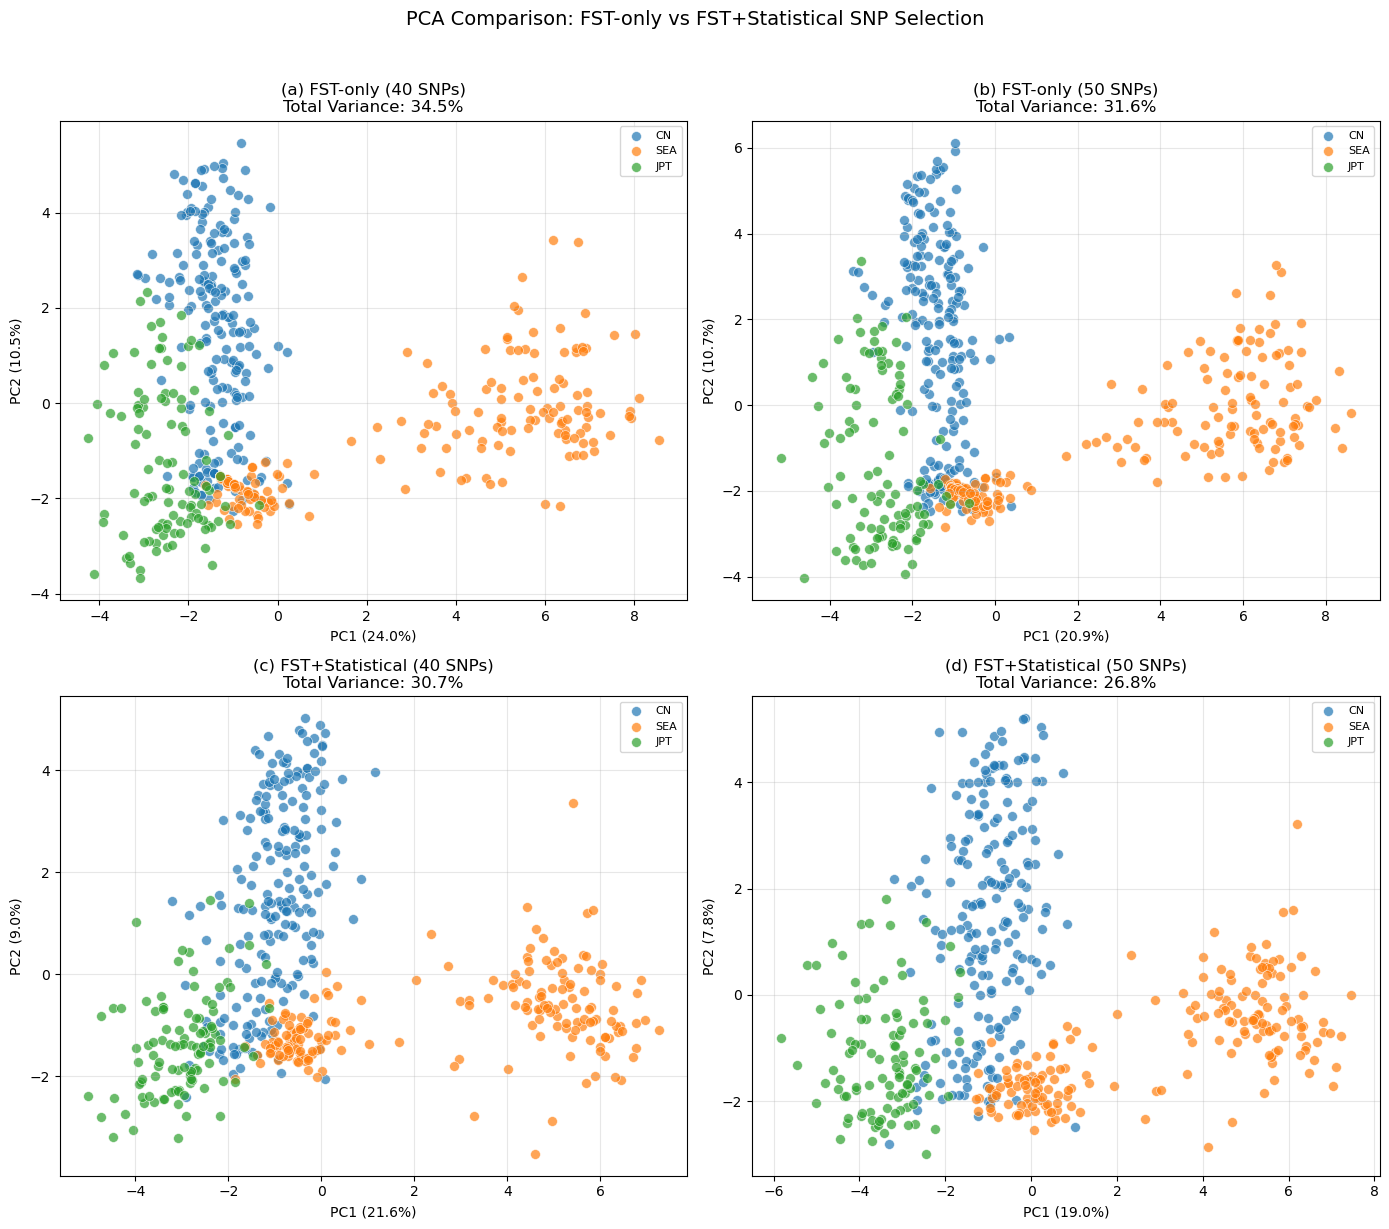

Plot saved: /home/Plutonium/Documents/BioinfoMidterm/graphs/part2/sea_jpt_cn/pca_fst_vs_statistical_comparison.png


In [66]:
# Visualization: PCA comparison (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Define colors for populations
populations = list(set(pca_datasets[list(pca_datasets.keys())[0]]['y']))
pop_colors = {pop: plt.cm.tab10(i) for i, pop in enumerate(populations)}

# Plot order
plot_order = [
    ('Our_FST_only_40', '(a) FST-only (40 SNPs)'),
    ('Our_FST_only_50', '(b) FST-only (50 SNPs)'),
    ('Our_FST_Statistical_40', '(c) FST+Statistical (40 SNPs)'),
    ('Our_FST_Statistical_50', '(d) FST+Statistical (50 SNPs)')
]

for idx, (name, title) in enumerate(plot_order):
    ax = axes.flat[idx]
    
    if name in pca_datasets:
        data = pca_datasets[name]
        X_pca = data['X_pca']
        y = data['y']
        var = data['explained_variance']
        
        # Plot each population
        for pop in populations:
            mask = y == pop
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=[pop_colors[pop]], label=pop, alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
        
        ax.set_xlabel(f'PC1 ({var[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({var[1]*100:.1f}%)')
        ax.set_title(f'{title}\nTotal Variance: {(var[0]+var[1])*100:.1f}%')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'{name}\nNot Available', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)

plt.suptitle('PCA Comparison: FST-only vs FST+Statistical SNP Selection', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'pca_fst_vs_statistical_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved: {GRAPHS_DIR / 'pca_fst_vs_statistical_comparison.png'}")

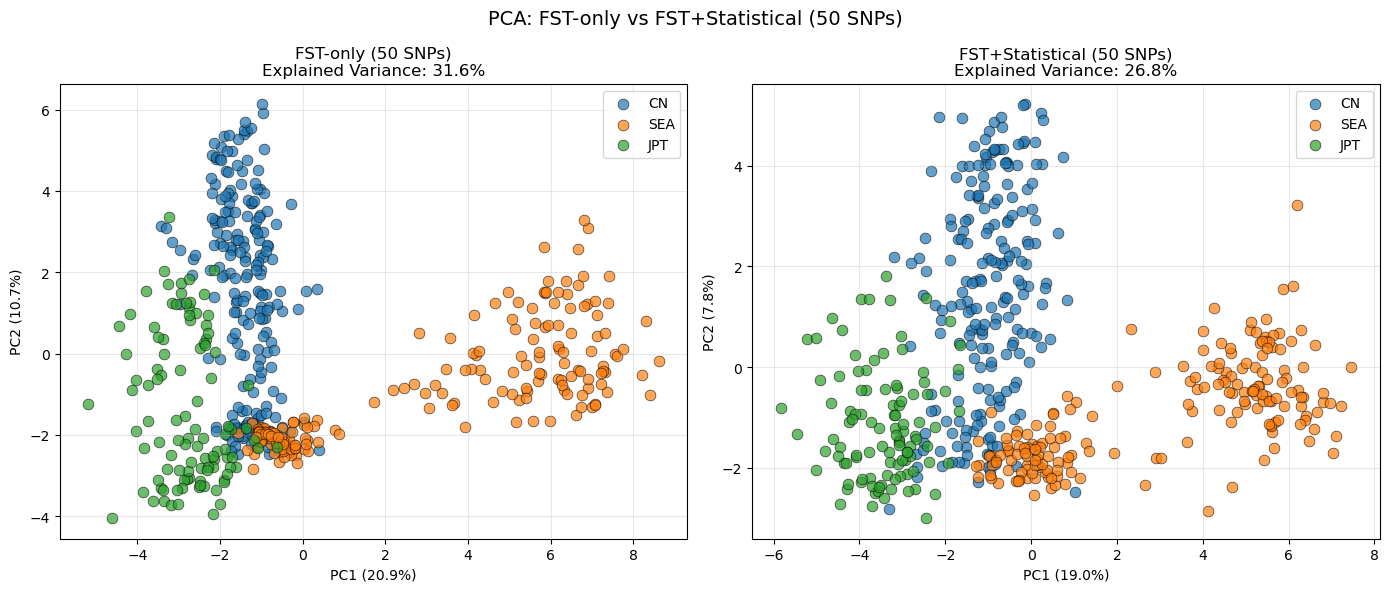


PCA EXPLAINED VARIANCE COMPARISON
Our_FST_only_40:
  PC1: 24.01%
  PC2: 10.52%
  Total (PC1+PC2): 34.54%
Our_FST_only_50:
  PC1: 20.88%
  PC2: 10.72%
  Total (PC1+PC2): 31.60%
Our_FST_Statistical_40:
  PC1: 21.62%
  PC2: 9.04%
  Total (PC1+PC2): 30.66%
Our_FST_Statistical_50:
  PC1: 18.97%
  PC2: 7.80%
  Total (PC1+PC2): 26.77%


In [67]:
# Direct comparison: FST-only vs FST+Statistical (50 SNPs) side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

compare_pairs = [
    ('Our_FST_only_50', 'FST-only (50 SNPs)'),
    ('Our_FST_Statistical_50', 'FST+Statistical (50 SNPs)')
]

for idx, (name, title) in enumerate(compare_pairs):
    ax = axes[idx]
    
    if name in pca_datasets:
        data = pca_datasets[name]
        X_pca = data['X_pca']
        y = data['y']
        var = data['explained_variance']
        
        for pop in populations:
            mask = y == pop
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=[pop_colors[pop]], label=pop, alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel(f'PC1 ({var[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({var[1]*100:.1f}%)')
        ax.set_title(f'{title}\nExplained Variance: {(var[0]+var[1])*100:.1f}%')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)

plt.suptitle('PCA: FST-only vs FST+Statistical (50 SNPs)', fontsize=14)
plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'pca_fst_vs_statistical_50snps.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print explained variance comparison
print("\n" + "="*60)
print("PCA EXPLAINED VARIANCE COMPARISON")
print("="*60)
for name in pca_datasets:
    var = pca_datasets[name]['explained_variance']
    print(f"{name}:")
    print(f"  PC1: {var[0]*100:.2f}%")
    print(f"  PC2: {var[1]*100:.2f}%")
    print(f"  Total (PC1+PC2): {(var[0]+var[1])*100:.2f}%")

## Step 6b: Compare Accuracy Across SNP Counts (25-50)

This section compares FST-only (04a) and FST+Statistical (04b) methods across varying numbers of SNPs (25-50) and calculates efficiency metrics (accuracy per SNP).

In [68]:
# Load varying SNP results from 04a (FST-only) and 04b (FST+Statistical)
ML_MODELS_DIR = project_root / "output" / "ml_models" / "sea_jpt_cn"
OUTPUT_SEA_DIR = project_root / "1000genomes" / "output_sea_jpt_cn"

# FST-only results (from 04a_ml_training.ipynb)
fst_feature_size_path = ML_MODELS_DIR / "feature_size_results.csv"
# FST+Statistical results (from 04b_fst_and_stat_training.ipynb)
stat_varying_snp_path = OUTPUT_SEA_DIR / "varying_snp_results.csv"

print("Loading varying SNP results...")
print(f"  FST-only path: {fst_feature_size_path}")
print(f"  FST+Statistical path: {stat_varying_snp_path}")

# Load FST-only results
if fst_feature_size_path.exists():
    fst_varying = pd.read_csv(fst_feature_size_path)
    fst_varying['Method'] = 'FST-only'
    # Rename columns for consistency
    fst_varying = fst_varying.rename(columns={'N_Features': 'N_SNPs', 'Accuracy_Mean': 'Accuracy'})
    print(f"\nFST-only results: {fst_varying.shape}")
    print(f"  SNP counts: {sorted(fst_varying['N_SNPs'].unique())}")
    print(f"  Models: {list(fst_varying['Model'].unique())}")
else:
    print(f"WARNING: FST-only results not found at {fst_feature_size_path}")
    fst_varying = None

# Load FST+Statistical results
if stat_varying_snp_path.exists():
    stat_varying = pd.read_csv(stat_varying_snp_path)
    stat_varying['Method'] = 'FST+Statistical'
    print(f"\nFST+Statistical results: {stat_varying.shape}")
    print(f"  SNP counts: {sorted(stat_varying['N_SNPs'].unique())}")
    print(f"  Models: {list(stat_varying['Model'].unique())}")
else:
    print(f"WARNING: FST+Statistical results not found at {stat_varying_snp_path}")
    stat_varying = None

Loading varying SNP results...
  FST-only path: /home/Plutonium/Documents/BioinfoMidterm/output/ml_models/sea_jpt_cn/feature_size_results.csv
  FST+Statistical path: /home/Plutonium/Documents/BioinfoMidterm/1000genomes/output_sea_jpt_cn/varying_snp_results.csv

FST-only results: (50, 5)
  SNP counts: [np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50)]
  Models: ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM (RBF)', 'Gradient Boosting']

FST+Statistical results: (6, 7)
  SNP counts: [np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50)]
  Models: ['Random Forest']


In [69]:
# Filter to common SNP counts (25-50 range) and combine
if fst_varying is not None and stat_varying is not None:
    # Find common SNP counts in the 25-50 range
    fst_snp_counts = set(fst_varying['N_SNPs'].unique())
    stat_snp_counts = set(stat_varying['N_SNPs'].unique())
    
    # Focus on 25-50 range
    target_range = {25, 30, 35, 40, 45, 50}
    common_snp_counts = sorted(fst_snp_counts.intersection(stat_snp_counts).intersection(target_range))
    
    print(f"Common SNP counts in 25-50 range: {common_snp_counts}")
    
    # Filter both datasets
    fst_filtered = fst_varying[fst_varying['N_SNPs'].isin(common_snp_counts)].copy()
    stat_filtered = stat_varying[stat_varying['N_SNPs'].isin(common_snp_counts)].copy()
    
    # Standardize column names (stat_varying might have 'F1-Score' instead of 'F1')
    if 'F1-Score' in stat_filtered.columns:
        stat_filtered = stat_filtered.rename(columns={'F1-Score': 'F1'})
    
    # Combine datasets
    combined_varying = pd.concat([fst_filtered, stat_filtered], ignore_index=True)
    
    # Find common models
    common_models = list(set(fst_filtered['Model'].unique()).intersection(set(stat_filtered['Model'].unique())))
    print(f"Common models: {common_models}")
    
    # Filter to common models
    combined_varying = combined_varying[combined_varying['Model'].isin(common_models)]
    
    print(f"\nCombined varying SNP results: {combined_varying.shape}")
    display(combined_varying.head(10))
else:
    print("Cannot proceed - missing one or both result files")
    combined_varying = None

Common SNP counts in 25-50 range: [25, 30, 35, 40, 45, 50]
Common models: ['Random Forest']

Combined varying SNP results: (12, 8)


,N_SNPs,Model,Accuracy,Accuracy_Std,Method,F1,CV Mean,CV Std
0,25,Random Forest,0.868990,0.039035,FST-only,NaN,NaN,NaN
5,30,Random Forest,0.896752,0.037105,FST-only,NaN,NaN,NaN
10,35,Random Forest,0.896752,0.040151,FST-only,NaN,NaN,NaN
15,40,Random Forest,0.910733,0.023365,FST-only,NaN,NaN,NaN
20,45,Random Forest,0.910713,0.010852,FST-only,NaN,NaN,NaN
25,50,Random Forest,0.934515,0.004970,FST-only,NaN,NaN,NaN
30,25,Random Forest,0.841584,NaN,FST+Statistical,0.837144,0.885957,0.023610
31,30,Random Forest,0.861386,NaN,FST+Statistical,0.857608,0.883426,0.019864
32,35,Random Forest,0.881188,NaN,FST+Statistical,0.878901,0.903272,0.016172
33,40,Random Forest,0.900990,NaN,FST+Statistical,0.900489,0.913179,0.013363


In [70]:
# Create pivot tables for comparison
if combined_varying is not None:
    print("="*70)
    print("ACCURACY COMPARISON: FST-only vs FST+Statistical (25-50 SNPs)")
    print("="*70)
    
    # Pivot tables
    fst_pivot = fst_filtered.pivot(index='Model', columns='N_SNPs', values='Accuracy')
    stat_pivot = stat_filtered.pivot(index='Model', columns='N_SNPs', values='Accuracy')
    
    # Align to common models
    fst_pivot = fst_pivot.loc[fst_pivot.index.intersection(common_models)]
    stat_pivot = stat_pivot.loc[stat_pivot.index.intersection(common_models)]
    
    print("\nFST-only Accuracy by Model and SNP Count:")
    display(fst_pivot.round(4))
    
    print("\nFST+Statistical Accuracy by Model and SNP Count:")
    display(stat_pivot.round(4))
    
    # Calculate difference
    diff_pivot = stat_pivot - fst_pivot
    print("\nDifference (FST+Statistical - FST-only):")
    print("Positive = FST+Statistical better, Negative = FST-only better")
    display(diff_pivot.round(4))

ACCURACY COMPARISON: FST-only vs FST+Statistical (25-50 SNPs)

FST-only Accuracy by Model and SNP Count:


N_SNPs,25,30,35,40,45,50
Model,,,,,,
Random Forest,0.869,0.8968,0.8968,0.9107,0.9107,0.9345



FST+Statistical Accuracy by Model and SNP Count:


N_SNPs,25,30,35,40,45,50
Model,,,,,,
Random Forest,0.8416,0.8614,0.8812,0.901,0.9208,0.8911



Difference (FST+Statistical - FST-only):
Positive = FST+Statistical better, Negative = FST-only better


N_SNPs,25,30,35,40,45,50
Model,,,,,,
Random Forest,-0.0274,-0.0354,-0.0156,-0.0097,0.0101,-0.0434


In [71]:
# Calculate Accuracy/SNP Efficiency Ratio
if combined_varying is not None:
    print("="*70)
    print("EFFICIENCY ANALYSIS: ACCURACY PER SNP")
    print("="*70)
    
    # Add efficiency metric (Accuracy / N_SNPs * 100 for readability)
    combined_varying['Efficiency'] = combined_varying['Accuracy'] / combined_varying['N_SNPs'] * 100
    
    # Best accuracy/SNP ratio by method
    efficiency_summary = combined_varying.groupby(['Method', 'N_SNPs']).agg({
        'Accuracy': 'max',
        'Efficiency': 'max'
    }).reset_index()
    
    print("\nBest Accuracy and Efficiency per Method and SNP Count:")
    display(efficiency_summary.round(4))
    
    # Find optimal configuration (best efficiency)
    print("\n" + "-"*70)
    print("OPTIMAL CONFIGURATIONS (Best Accuracy/SNP Ratio)")
    print("-"*70)
    
    for method in ['FST-only', 'FST+Statistical']:
        method_data = combined_varying[combined_varying['Method'] == method]
        best_eff_idx = method_data['Efficiency'].idxmax()
        best_eff = method_data.loc[best_eff_idx]
        
        # Also find best accuracy regardless of efficiency
        best_acc_idx = method_data['Accuracy'].idxmax()
        best_acc = method_data.loc[best_acc_idx]
        
        print(f"\n{method}:")
        print(f"  Best Efficiency: {best_eff['Model']} with {int(best_eff['N_SNPs'])} SNPs")
        print(f"    Accuracy: {best_eff['Accuracy']:.4f}, Efficiency: {best_eff['Efficiency']:.4f}% per SNP")
        print(f"  Best Accuracy: {best_acc['Model']} with {int(best_acc['N_SNPs'])} SNPs")
        print(f"    Accuracy: {best_acc['Accuracy']:.4f}, Efficiency: {best_acc['Efficiency']:.4f}% per SNP")

EFFICIENCY ANALYSIS: ACCURACY PER SNP

Best Accuracy and Efficiency per Method and SNP Count:


,Method,N_SNPs,Accuracy,Efficiency
0,FST+Statistical,25,0.8416,3.3663
1,FST+Statistical,30,0.8614,2.8713
2,FST+Statistical,35,0.8812,2.5177
3,FST+Statistical,40,0.9010,2.2525
4,FST+Statistical,45,0.9208,2.0462
5,FST+Statistical,50,0.8911,1.7822
6,FST-only,25,0.8690,3.4760
7,FST-only,30,0.8968,2.9892
8,FST-only,35,0.8968,2.5621
9,FST-only,40,0.9107,2.2768



----------------------------------------------------------------------
OPTIMAL CONFIGURATIONS (Best Accuracy/SNP Ratio)
----------------------------------------------------------------------



FST-only:
  Best Efficiency: Random Forest with 25 SNPs
    Accuracy: 0.8690, Efficiency: 3.4760% per SNP
  Best Accuracy: Random Forest with 50 SNPs
    Accuracy: 0.9345, Efficiency: 1.8690% per SNP

FST+Statistical:
  Best Efficiency: Random Forest with 25 SNPs
    Accuracy: 0.8416, Efficiency: 3.3663% per SNP
  Best Accuracy: Random Forest with 45 SNPs
    Accuracy: 0.9208, Efficiency: 2.0462% per SNP


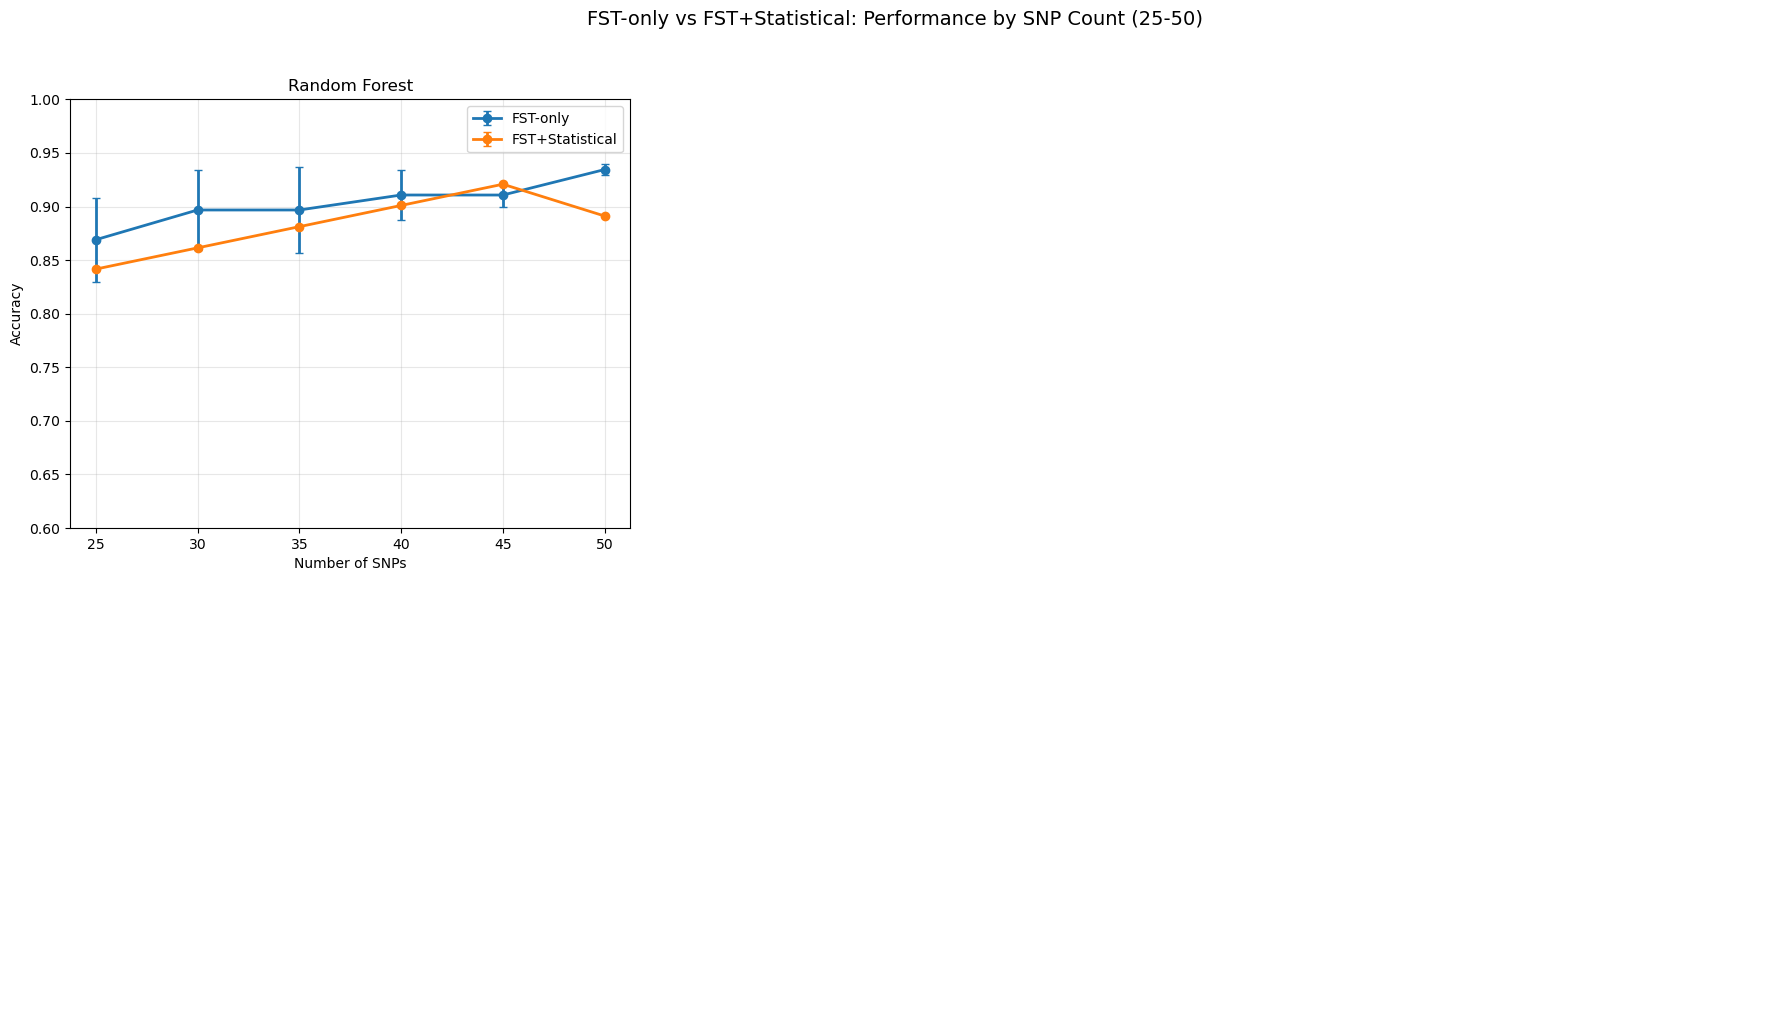

Plot saved to: /home/Plutonium/Documents/BioinfoMidterm/graphs/part2/sea_jpt_cn/method_comparison_by_snp_count.png


In [72]:
# Visualization: Accuracy vs SNP Count Comparison
if combined_varying is not None:
    method_colors = {'FST-only': '#1f77b4', 'FST+Statistical': '#ff7f0e'}
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Top models to compare
    top_models = ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM (RBF)', 'Gradient Boosting']
    available_models = [m for m in top_models if m in common_models]
    
    for idx, model in enumerate(available_models):
        ax = axes.flat[idx]
        
        for method, color in method_colors.items():
            method_data = combined_varying[
                (combined_varying['Method'] == method) & 
                (combined_varying['Model'] == model)
            ].sort_values('N_SNPs')
            
            if len(method_data) > 0:
                if 'Accuracy_Std' in method_data.columns:
                    ax.errorbar(method_data['N_SNPs'], method_data['Accuracy'],
                               yerr=method_data['Accuracy_Std'], marker='o', label=method,
                               color=color, capsize=3, linewidth=2, markersize=6)
                else:
                    ax.plot(method_data['N_SNPs'], method_data['Accuracy'],
                           marker='o', label=method, color=color, linewidth=2, markersize=6)
        
        ax.set_xlabel('Number of SNPs')
        ax.set_ylabel('Accuracy')
        ax.set_title(model)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0.6, 1.0)
    
    # Hide empty subplots
    for idx in range(len(available_models), 6):
        axes.flat[idx].axis('off')
    
    plt.suptitle('FST-only vs FST+Statistical: Performance by SNP Count (25-50)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(str(GRAPHS_DIR / 'method_comparison_by_snp_count.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {GRAPHS_DIR / 'method_comparison_by_snp_count.png'}")

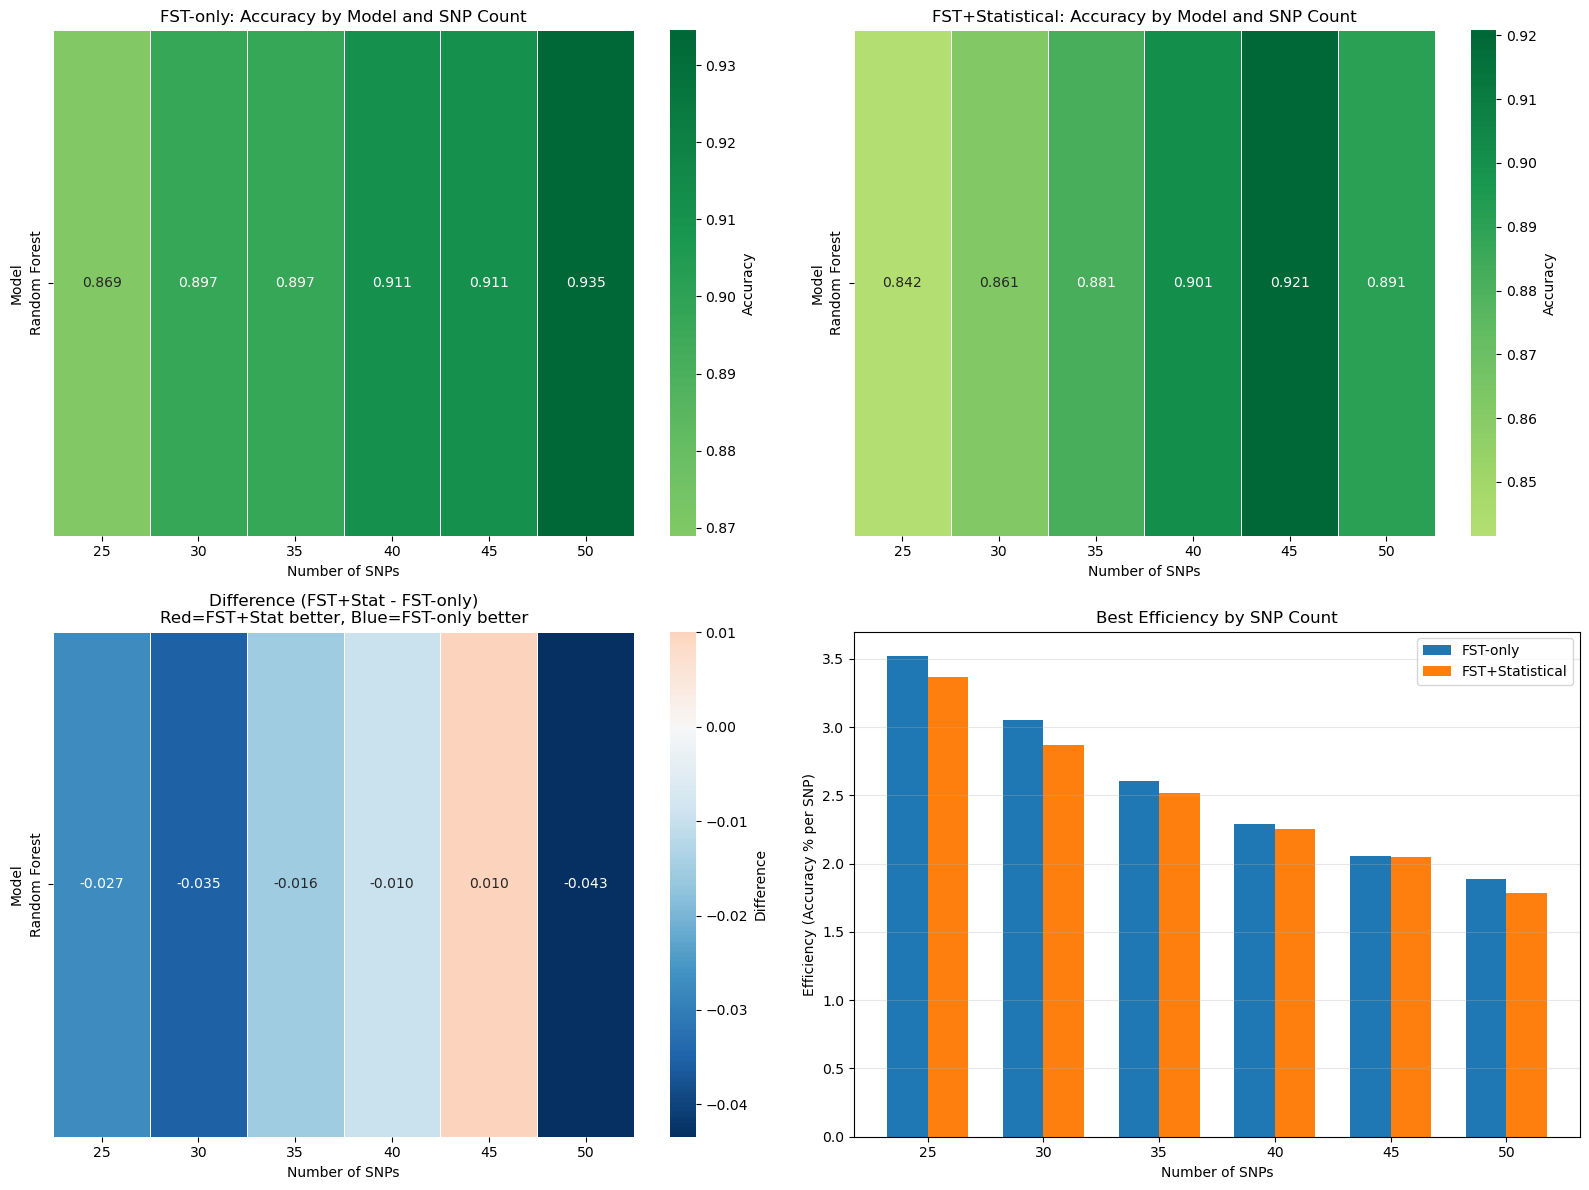

Plot saved to: /home/Plutonium/Documents/BioinfoMidterm/graphs/part2/sea_jpt_cn/method_comparison_heatmaps.png


In [73]:
# Additional visualizations: Heatmaps and Efficiency plots
if combined_varying is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: FST-only Accuracy Heatmap
    ax = axes[0, 0]
    sns.heatmap(fst_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                center=0.8, linewidths=0.5, ax=ax, cbar_kws={'label': 'Accuracy'})
    ax.set_title('FST-only: Accuracy by Model and SNP Count')
    ax.set_xlabel('Number of SNPs')
    ax.set_ylabel('Model')
    
    # Plot 2: FST+Statistical Accuracy Heatmap
    ax = axes[0, 1]
    sns.heatmap(stat_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                center=0.8, linewidths=0.5, ax=ax, cbar_kws={'label': 'Accuracy'})
    ax.set_title('FST+Statistical: Accuracy by Model and SNP Count')
    ax.set_xlabel('Number of SNPs')
    ax.set_ylabel('Model')
    
    # Plot 3: Difference Heatmap
    ax = axes[1, 0]
    sns.heatmap(diff_pivot, annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, linewidths=0.5, ax=ax, cbar_kws={'label': 'Difference'})
    ax.set_title('Difference (FST+Stat - FST-only)\nRed=FST+Stat better, Blue=FST-only better')
    ax.set_xlabel('Number of SNPs')
    ax.set_ylabel('Model')
    
    # Plot 4: Efficiency comparison
    ax = axes[1, 1]
    
    # Calculate efficiency pivot tables
    fst_eff = fst_filtered.copy()
    fst_eff['Efficiency'] = fst_eff['Accuracy'] / fst_eff['N_SNPs'] * 100
    stat_eff = stat_filtered.copy()
    stat_eff['Efficiency'] = stat_eff['Accuracy'] / stat_eff['N_SNPs'] * 100
    
    # Best efficiency per SNP count for each method
    fst_best_eff = fst_eff.groupby('N_SNPs')['Efficiency'].max()
    stat_best_eff = stat_eff.groupby('N_SNPs')['Efficiency'].max()
    
    x = np.arange(len(common_snp_counts))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, [fst_best_eff.get(n, 0) for n in common_snp_counts], 
                   width, label='FST-only', color='#1f77b4')
    bars2 = ax.bar(x + width/2, [stat_best_eff.get(n, 0) for n in common_snp_counts], 
                   width, label='FST+Statistical', color='#ff7f0e')
    
    ax.set_xlabel('Number of SNPs')
    ax.set_ylabel('Efficiency (Accuracy % per SNP)')
    ax.set_title('Best Efficiency by SNP Count')
    ax.set_xticks(x)
    ax.set_xticklabels(common_snp_counts)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(str(GRAPHS_DIR / 'method_comparison_heatmaps.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {GRAPHS_DIR / 'method_comparison_heatmaps.png'}")

In [74]:
# Statistical significance testing for varying SNP counts
from scipy import stats

if combined_varying is not None:
    print("="*70)
    print("STATISTICAL SIGNIFICANCE: FST-only vs FST+Statistical")
    print("="*70)
    
    significance_results = []
    
    for n_snps in common_snp_counts:
        fst_acc = fst_filtered[fst_filtered['N_SNPs'] == n_snps].set_index('Model')['Accuracy']
        stat_acc = stat_filtered[stat_filtered['N_SNPs'] == n_snps].set_index('Model')['Accuracy']
        
        # Align by model
        common_idx = fst_acc.index.intersection(stat_acc.index)
        fst_aligned = fst_acc.loc[common_idx]
        stat_aligned = stat_acc.loc[common_idx]
        
        if len(common_idx) >= 3:  # Need at least 3 pairs for Wilcoxon
            t_stat, p_value = stats.ttest_rel(stat_aligned, fst_aligned)
            mean_diff = stat_aligned.mean() - fst_aligned.mean()
            
            significance_results.append({
                'N_SNPs': n_snps,
                'FST_Mean': fst_aligned.mean(),
                'Stat_Mean': stat_aligned.mean(),
                'Difference': mean_diff,
                't_statistic': t_stat,
                'p_value': p_value,
                'Significant': 'Yes*' if p_value < 0.05 else 'No'
            })
            
            sig = "*" if p_value < 0.05 else ""
            print(f"{n_snps} SNPs: FST={fst_aligned.mean():.4f}, Stat={stat_aligned.mean():.4f}, "
                  f"Diff={mean_diff:+.4f}, p={p_value:.4f} {sig}")
    
    sig_df = pd.DataFrame(significance_results)
    print("\n* indicates p < 0.05")
    
    # Overall comparison
    print("\n" + "-"*70)
    print("Overall Comparison (Wilcoxon signed-rank test):")
    
    # Merge on Model and N_SNPs
    merged = fst_filtered.merge(stat_filtered, on=['Model', 'N_SNPs'], suffixes=('_FST', '_Stat'))
    
    if len(merged) >= 5:
        stat_test, p_val = stats.wilcoxon(merged['Accuracy_Stat'], merged['Accuracy_FST'])
        print(f"  Wilcoxon statistic: {stat_test:.4f}")
        print(f"  p-value: {p_val:.4f}")
        print(f"  Significant difference: {'Yes' if p_val < 0.05 else 'No'}")
        
        # Effect size (rank-biserial correlation)
        n = len(merged)
        r = 1 - (2 * stat_test) / (n * (n + 1) / 2)
        print(f"  Effect size (r): {r:.4f}")

STATISTICAL SIGNIFICANCE: FST-only vs FST+Statistical

* indicates p < 0.05

----------------------------------------------------------------------
Overall Comparison (Wilcoxon signed-rank test):
  Wilcoxon statistic: 2.0000
  p-value: 0.0938
  Significant difference: No
  Effect size (r): 0.8095


In [75]:
# Summary: Best configurations and efficiency analysis
if combined_varying is not None:
    print("="*70)
    print("SUMMARY: BEST CONFIGURATIONS (25-50 SNPs)")
    print("="*70)
    
    # Best by method
    for method in ['FST-only', 'FST+Statistical']:
        method_data = combined_varying[combined_varying['Method'] == method]
        
        # Best accuracy
        best_acc_idx = method_data['Accuracy'].idxmax()
        best_acc = method_data.loc[best_acc_idx]
        
        # Best efficiency (accuracy/SNP)
        best_eff_idx = method_data['Efficiency'].idxmax()
        best_eff = method_data.loc[best_eff_idx]
        
        print(f"\n{method}:")
        print(f"  ★ Best Accuracy: {best_acc['Accuracy']:.4f}")
        print(f"      Model: {best_acc['Model']}, SNPs: {int(best_acc['N_SNPs'])}")
        print(f"  ★ Best Efficiency: {best_eff['Efficiency']:.4f}% per SNP")
        print(f"      Model: {best_eff['Model']}, SNPs: {int(best_eff['N_SNPs'])}, Accuracy: {best_eff['Accuracy']:.4f}")
    
    # Overall winner
    print("\n" + "-"*70)
    print("OVERALL COMPARISON")
    print("-"*70)
    
    fst_best_acc = combined_varying[combined_varying['Method'] == 'FST-only']['Accuracy'].max()
    stat_best_acc = combined_varying[combined_varying['Method'] == 'FST+Statistical']['Accuracy'].max()
    fst_best_eff = combined_varying[combined_varying['Method'] == 'FST-only']['Efficiency'].max()
    stat_best_eff = combined_varying[combined_varying['Method'] == 'FST+Statistical']['Efficiency'].max()
    
    print(f"\nBest Accuracy:")
    print(f"  FST-only: {fst_best_acc:.4f}")
    print(f"  FST+Statistical: {stat_best_acc:.4f}")
    print(f"  Winner: {'FST+Statistical' if stat_best_acc > fst_best_acc else 'FST-only'} (+{abs(stat_best_acc - fst_best_acc):.4f})")
    
    print(f"\nBest Efficiency (Accuracy/SNP):")
    print(f"  FST-only: {fst_best_eff:.4f}% per SNP")
    print(f"  FST+Statistical: {stat_best_eff:.4f}% per SNP")
    print(f"  Winner: {'FST+Statistical' if stat_best_eff > fst_best_eff else 'FST-only'} (+{abs(stat_best_eff - fst_best_eff):.4f})")

SUMMARY: BEST CONFIGURATIONS (25-50 SNPs)

FST-only:
  ★ Best Accuracy: 0.9345
      Model: Random Forest, SNPs: 50
  ★ Best Efficiency: 3.4760% per SNP
      Model: Random Forest, SNPs: 25, Accuracy: 0.8690

FST+Statistical:
  ★ Best Accuracy: 0.9208
      Model: Random Forest, SNPs: 45
  ★ Best Efficiency: 3.3663% per SNP
      Model: Random Forest, SNPs: 25, Accuracy: 0.8416

----------------------------------------------------------------------
OVERALL COMPARISON
----------------------------------------------------------------------

Best Accuracy:
  FST-only: 0.9345
  FST+Statistical: 0.9208
  Winner: FST-only (+0.0137)

Best Efficiency (Accuracy/SNP):
  FST-only: 3.4760% per SNP
  FST+Statistical: 3.3663% per SNP
  Winner: FST-only (+0.1096)


In [76]:
# Save varying SNP comparison results
if combined_varying is not None:
    # Save combined results
    combined_path = str(PART2_DIR / "method_varying_snp_comparison.csv")
    combined_varying.to_csv(combined_path, index=False)
    print(f"Varying SNP comparison saved: {combined_path}")
    
    # Save efficiency summary
    efficiency_path = str(PART2_DIR / "method_efficiency_comparison.csv")
    efficiency_summary.to_csv(efficiency_path, index=False)
    print(f"Efficiency summary saved: {efficiency_path}")
    
    # Save significance results
    if len(significance_results) > 0:
        sig_path = str(PART2_DIR / "method_varying_snp_significance.csv")
        sig_df.to_csv(sig_path, index=False)
        print(f"Significance results saved: {sig_path}")
    
    # Save difference matrix
    diff_path = str(PART2_DIR / "method_varying_snp_difference.csv")
    diff_pivot.to_csv(diff_path)
    print(f"Difference matrix saved: {diff_path}")

Varying SNP comparison saved: /home/Plutonium/Documents/BioinfoMidterm/output/part2/sea_jpt_cn/method_varying_snp_comparison.csv
Efficiency summary saved: /home/Plutonium/Documents/BioinfoMidterm/output/part2/sea_jpt_cn/method_efficiency_comparison.csv
Difference matrix saved: /home/Plutonium/Documents/BioinfoMidterm/output/part2/sea_jpt_cn/method_varying_snp_difference.csv


## Step 7: Statistical Significance

In [77]:
from scipy import stats

print("="*70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*70)

# Our methods vs Known panels
our_acc = results_df[results_df['Type'] == 'Our Selection']['Accuracy_Mean']
known_acc = results_df[results_df['Type'] == 'Known Panel']['Accuracy_Mean']

print("\n1. Our Selections vs Known Panels (Mann-Whitney U):")
stat, p_val = stats.mannwhitneyu(our_acc, known_acc, alternative='two-sided')
print(f"   U-statistic: {stat:.4f}")
print(f"   p-value: {p_val:.4f}")
print(f"   Significant (α=0.05): {'Yes' if p_val < 0.05 else 'No'}")

# FST-only vs FST+Statistical
if 'Our_FST_only' in results_df['Source'].values and 'Our_FST_Statistical' in results_df['Source'].values:
    print("\n2. FST-only vs FST+Statistical (Wilcoxon signed-rank):")
    
    fst_data = results_df[results_df['Source'] == 'Our_FST_only'].set_index('Model')['Accuracy_Mean']
    stat_data = results_df[results_df['Source'] == 'Our_FST_Statistical'].set_index('Model')['Accuracy_Mean']
    common = fst_data.index.intersection(stat_data.index)
    
    stat, p_val = stats.wilcoxon(stat_data.loc[common], fst_data.loc[common])
    print(f"   W-statistic: {stat:.4f}")
    print(f"   p-value: {p_val:.4f}")
    print(f"   Significant (α=0.05): {'Yes' if p_val < 0.05 else 'No'}")

STATISTICAL SIGNIFICANCE TESTING

1. Our Selections vs Known Panels (Mann-Whitney U):
   U-statistic: 916.0000
   p-value: 0.0000
   Significant (α=0.05): Yes


## Step 8: Save Results

In [78]:
# Save all results
results_path = str(PART2_DIR / "our_vs_known_comparison_results.csv")
results_df.to_csv(results_path, index=False)
print(f"Results saved: {results_path}")

# Save summary
summary_path = str(PART2_DIR / "our_vs_known_summary.csv")
source_summary.to_csv(summary_path)
print(f"Summary saved: {summary_path}")

Results saved: /home/Plutonium/Documents/BioinfoMidterm/output/part2/sea_jpt_cn/our_vs_known_comparison_results.csv
Summary saved: /home/Plutonium/Documents/BioinfoMidterm/output/part2/sea_jpt_cn/our_vs_known_summary.csv


## Summary

In [79]:
print("="*70)
print("OUR SNPS EVALUATION SUMMARY")
print("="*70)

# Our methods summary
our_sources = ['Our_FST_only_40', 'Our_FST_only_50', 'Our_FST_Statistical_40', 'Our_FST_Statistical_50']
print("\nOur SNP Selection Methods:")

for source in our_sources:
    if source in results_df['Source'].values:
        source_data = results_df[results_df['Source'] == source]
        n_snps = source_data['N_SNPs'].iloc[0]
        best_acc = source_data['Accuracy_Mean'].max()
        best_model = source_data.loc[source_data['Accuracy_Mean'].idxmax(), 'Model']
        avg_acc = source_data['Accuracy_Mean'].mean()
        
        print(f"\n  ★ {source}:")
        print(f"      SNPs: {n_snps}")
        print(f"      Best: {best_model} ({best_acc:.4f})")
        print(f"      Average across models: {avg_acc:.4f}")

# Find our overall best
our_results = results_df[results_df['Type'] == 'Our Selection']
if len(our_results) > 0:
    best_our_idx = our_results['Accuracy_Mean'].idxmax()
    best_our = our_results.loc[best_our_idx]
    print(f"\n  ⭐ BEST OVERALL (Our Methods):")
    print(f"      {best_our['Source']} with {best_our['Model']}")
    print(f"      Accuracy: {best_our['Accuracy_Mean']:.4f}")

# Comparison with known panels
print("\n" + "-"*70)
print("Comparison with Known Panels:")
our_best = results_df[results_df['Type'] == 'Our Selection']['Accuracy_Mean'].max()
known_best = results_df[results_df['Type'] == 'Known Panel']['Accuracy_Mean'].max()

print(f"  Our best accuracy: {our_best:.4f}")
print(f"  Known panels best: {known_best:.4f}")

if our_best > known_best:
    print(f"  → Our selection outperforms known panels by {(our_best - known_best):.4f}")
elif our_best < known_best:
    print(f"  → Known panels outperform our selection by {(known_best - our_best):.4f}")
else:
    print(f"  → Our selection matches known panels")

# 40 vs 50 SNP recommendation
print("\n" + "-"*70)
print("40 vs 50 SNP RECOMMENDATION:")

for method in ['FST_only', 'FST_Statistical']:
    src_40 = f'Our_{method}_40'
    src_50 = f'Our_{method}_50'
    if src_40 in results_df['Source'].values and src_50 in results_df['Source'].values:
        acc_40 = results_df[results_df['Source'] == src_40]['Accuracy_Mean'].max()
        acc_50 = results_df[results_df['Source'] == src_50]['Accuracy_Mean'].max()
        
        diff = acc_50 - acc_40
        method_name = method.replace('_', '+')
        
        if abs(diff) < 0.01:
            rec = "40 SNPs (similar accuracy, more efficient)"
        elif diff > 0:
            rec = f"50 SNPs (+{diff:.4f} accuracy)"
        else:
            rec = f"40 SNPs (+{-diff:.4f} accuracy, fewer SNPs)"
        
        print(f"  {method_name}: {rec}")
        print(f"    40 SNPs: {acc_40:.4f}, 50 SNPs: {acc_50:.4f}")

print(f"\nOutput Files:")
print(f"  - {PART2_DIR / 'our_vs_known_comparison_results.csv'}")
print(f"  - {PART2_DIR / 'our_vs_known_summary.csv'}")
print(f"  - {GRAPHS_DIR / 'our_vs_known_*.png'}")
print(f"  - {GRAPHS_DIR / 'our_methods_40_vs_50_comparison.png'}")

OUR SNPS EVALUATION SUMMARY

Our SNP Selection Methods:

  ★ Our_FST_only_40:
      SNPs: 40
      Best: SVM (RBF) (0.9167)
      Average across models: 0.8968

  ★ Our_FST_only_50:
      SNPs: 50
      Best: SVM (RBF) (0.9445)
      Average across models: 0.9036

  ★ Our_FST_Statistical_40:
      SNPs: 40
      Best: SVM (RBF) (0.9147)
      Average across models: 0.8943

  ★ Our_FST_Statistical_50:
      SNPs: 50
      Best: SVM (RBF) (0.9285)
      Average across models: 0.9042

  ⭐ BEST OVERALL (Our Methods):
      Our_FST_only_50 with SVM (RBF)
      Accuracy: 0.9445

----------------------------------------------------------------------
Comparison with Known Panels:
  Our best accuracy: 0.9445
  Known panels best: 0.9107
  → Our selection outperforms known panels by 0.0338

----------------------------------------------------------------------
40 vs 50 SNP RECOMMENDATION:
  FST+only: 50 SNPs (+0.0278 accuracy)
    40 SNPs: 0.9167, 50 SNPs: 0.9445
  FST+Statistical: 50 SNPs (+0.01